In [33]:
import pandas as pd
import json
import requests

In [34]:
url = " https://seeclickfix.com/api/v2/issues?min_lat=39.03211937423035&min_lng=-95.71889877319336&max_lat=39.052118348329074&max_lng=-95.6312656402588&status=open%2Cacknowledged%2Cclosed&fields%5Bissue%5D=id%2Csummary%2Cdescription%2Cstatus%2Clat%2Clng%2Caddress%2Cmedia%2Ccreated_at%2Cacknowledged_at%2Cclosed_at&page=1"

In [36]:
response = requests.get(url).json()
total_pages = response['metadata']['pagination']['pages']

In [37]:
def get_issues(url):
    all_issues = []
    for i in range(1,total_pages +1):
        print(f"getting page {i} of {total_pages}")
        response = requests.get(url).json()
        next_page_url = response['metadata']['pagination']['next_page_url']
        page_issues = response['issues']
        all_issues.extend(page_issues)
        url = next_page_url
    return all_issues

In [38]:
all_issues = get_issues(url)

getting page 1 of 10
getting page 2 of 10
getting page 3 of 10
getting page 4 of 10
getting page 5 of 10
getting page 6 of 10
getting page 7 of 10
getting page 8 of 10
getting page 9 of 10
getting page 10 of 10


In [40]:
issues_df = pd.DataFrame(all_issues)

In [47]:
issues_df = issues_df.set_index('id')

In [49]:
status_list = issues_df['status'].value_counts()

Acknowledged    157
Closed           21
Open              4
Name: status, dtype: int64

In [59]:
summary_list = issues_df['summary'].value_counts()
summary_list

Property Maintenance & Code Violations    54
Curb and Gutter Repair                    43
Alley                                     14
Pothole                                   13
Sidewalk and Ramp                         10
Trees and Tree Limbs                       8
Police General Issue                       8
Street Repair                              4
Other                                      4
General Feedback or Questions              4
Snow or Ice Hazard                         3
Street Sign Repair                         3
Utility Work Damage                        2
dangerous parking                          1
Police Animal Control                      1
Downtown Parking General Question          1
Dead animal on sidewalk                    1
skatepark light                            1
Graffiti                                   1
Junk Yard?                                 1
Curb and Gutter                            1
safety lighting                            1
Loud pedes

In [56]:
summary_df = pd.DataFrame(issues_df.groupby('summary')['status'].count())

<AxesSubplot:xlabel='summary'>

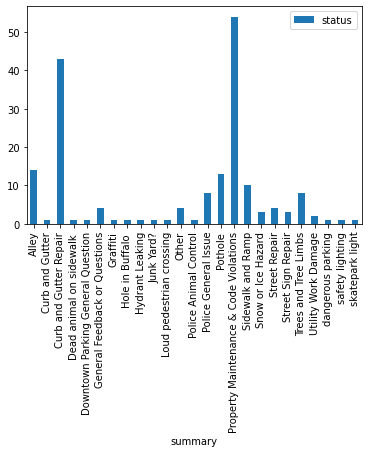

In [57]:
summary_df.plot(kind="bar")